In [1]:
include(joinpath(@__DIR__, "..", "..", "utils", "plot_utils.jl"))

overlay_posterior_on_observed (generic function with 1 method)

In [2]:
using CSV, DataFrames

df = CSV.read("../../case_study_1/python/data/phaeocystis_control.csv", DataFrame)

times    = df.times
y_obs    = df.cells

nothing

In [3]:
function ode(du, u, p, t)
    mum = p[1]
    y = u[1]
    du[1] = mum * y
    return nothing
end

ode (generic function with 1 method)

In [4]:
using Turing
@model function fit_ode(log_y_obs, times, prob)
    mum   ~ truncated(Normal(0.5, 0.3), 0.0, 1.0)
    N0    ~ LogNormal(log(1_630_000), 0.1)
    sigma ~ truncated(Normal(0, 1), 0, Inf)    
    
    # solve exactly at data times
    sol = solve(prob, Tsit5();
                u0 = [N0], p = mum, 
                tspan = (times[1], times[end]), saveat = times)

    # likelihood at observation times
    log_y_pred = log.(Array(sol)[1, :] .+ 1e-9)
    log_y_obs ~ arraydist(Normal.(log_y_pred, sigma))
end

fit_ode (generic function with 2 methods)

In [5]:
using DifferentialEquations

u0 = [y_obs[1]]
p = [0.5]
tspan = (times[1], times[end])
prob = ODEProblem(ode, u0, tspan, p)

log_y_obs = log.(y_obs .+ 1e-9)
model    = fit_ode(log_y_obs, times, prob)
chain    = sample(model, NUTS(1000, .95), MCMCSerial(), 1000, 3; progress=false)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215


Chains MCMC chain (1000×17×3 Array{Float64, 3}):

Iterations        = 1001:1:2000
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 10.3 seconds
Compute duration  = 8.28 seconds
parameters        = mum, N0, sigma
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


In [ ]:
using JLSO, MCMCChains

# save
JLSO.save("chains/myrun.jlso"; chain=chain)

# later…
using JLSO, MCMCChains
loaded = JLSO.load("chains/myrun.jlso")
chain2 = loaded[:chain]


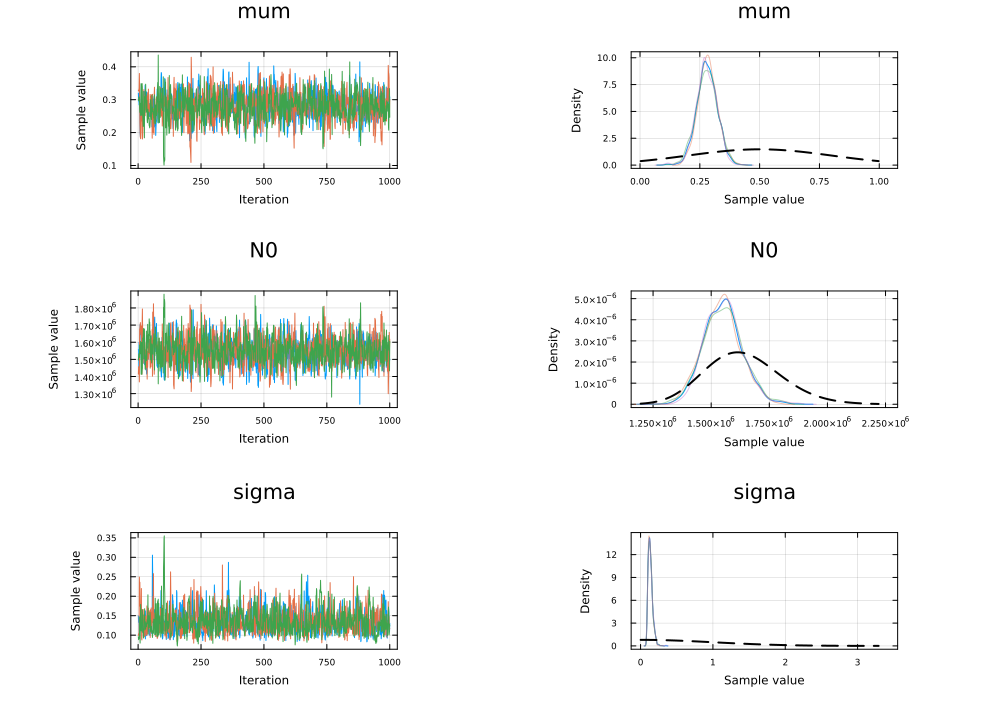

In [6]:
priors = Dict{Symbol,Distribution}(
    :mum   => truncated(Normal(0.5, 0.3), 0.0, 1.0),
    :N0    => LogNormal(log(1_630_000.0), 0.1),
    :sigma => truncated(Normal(0, 1.0), 0.0, Inf)
)

#plot_trace_with_priors(chain; priors=priors)                 # combined density + prior
# or:
order = [:mum, :N0, :sigma]
plot_trace_with_priors(chain; priors=priors, var_order=order, per_chain_density=true)  # also per-chain densities


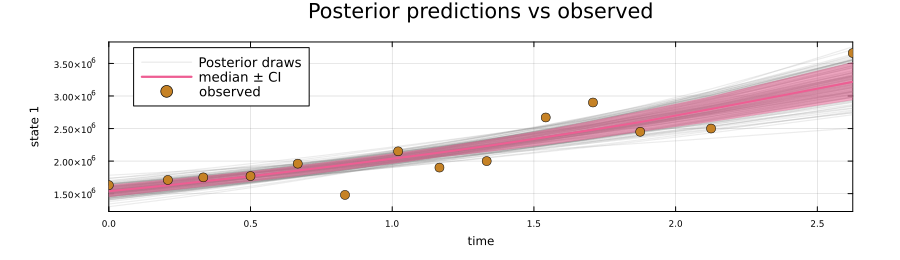

In [7]:
init_syms = [:N0]
param_syms = [:mum]
t_obs = times
y_obs = y_obs

plt = overlay_posterior_on_observed(
    chain, ode, t_obs, y_obs;
    init_syms=init_syms,
    param_syms=param_syms,
    which_states=[1],     # choose states to plot
    n_draws=150,            # how many posterior paths to overlay
    plot_ribbon=true,       # median ± CI band
    ribbon_q=(0.1, 0.9),    # CI limits
    legend=:topleft,
    logy=false
)
display(plt)

## Part 2

In [8]:
# from your data-prep cell
using CSV, DataFrames

df = CSV.read("../../case_study_1/python/data/phaeocystis_control.csv", DataFrame)

times    = df.times
y_obs    = df.cells

nothing

In [9]:
function ode(du, u, p, t)
    mum = p[1] 
    delta = p[2]
    y = u[1]
    du[1] = (mum - delta) * y
    return nothing
end

ode (generic function with 1 method)

In [10]:
using Turing
@model function fit_ode(log_y_obs, times, prob)
    mum   ~ truncated(Normal(0.5, 0.3), 0.0, 1.0)
    delta ~ truncated(Normal(0.5, 0.3), 0.0, 1.0)
    N0    ~ LogNormal(log(1_630_000), 0.1)
    sigma ~ truncated(Normal(0, 1), 0, Inf)    
    
    # solve exactly at data times
    sol = solve(prob, Tsit5();
                u0 = [N0], p = [mum, delta], 
                tspan = (times[1], times[end]), saveat = times)

    # likelihood at observation times
    log_y_pred = log.(Array(sol)[1, :] .+ 1e-9)
    log_y_obs ~ arraydist(Normal.(log_y_pred, sigma))
end

fit_ode (generic function with 2 methods)

In [11]:
using DifferentialEquations

u0 = [y_obs[1]]
p = [0.5, 0.5]
tspan = (times[1], times[end])
prob = ODEProblem(ode, u0, tspan, p)

log_y_obs = log.(y_obs .+ 1e-9)
model    = fit_ode(log_y_obs, times, prob)
chain    = sample(model, NUTS(1000, .95), MCMCSerial(), 1000, 3; progress=false)


┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215


Chains MCMC chain (1000×18×3 Array{Float64, 3}):

Iterations        = 1001:1:2000
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 11.28 seconds
Compute duration  = 10.9 seconds
parameters        = mum, delta, N0, sigma
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


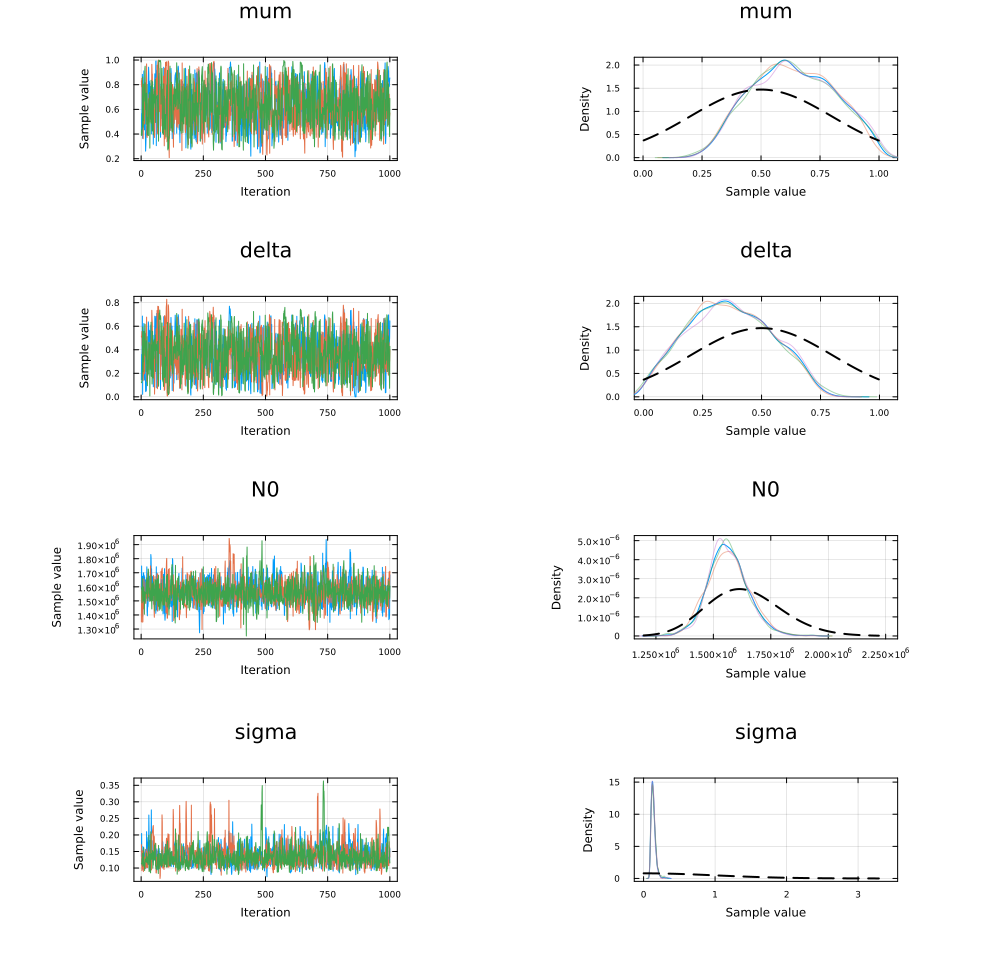

In [12]:

priors = Dict{Symbol,Distribution}(
    :mum   => truncated(Normal(0.5, 0.3), 0.0, 1.0),
    :delta => truncated(Normal(0.5, 0.3), 0.0, 1.0),
    :N0    => LogNormal(log(1_630_000.0), 0.1),
    :sigma => truncated(Normal(0, 1.0), 0.0, Inf)
)

#plot_trace_with_priors(chain; priors=priors)                 # combined density + prior
# or:
order = [:mum, :delta, :N0, :sigma]
plot_trace_with_priors(chain; priors=priors, var_order=order, per_chain_density=true)  # also per-chain densities

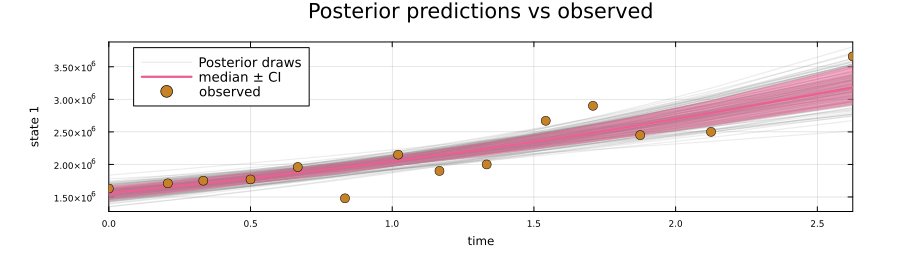

In [13]:
init_syms = [:N0]
param_syms = [:mum, :delta]
y_obs = y_obs
t_obs = times

plt = overlay_posterior_on_observed(
    chain, ode, t_obs, y_obs;
    init_syms=init_syms,
    param_syms=param_syms,
    which_states=[1],     # choose states to plot
    n_draws=150,            # how many posterior paths to overlay
    plot_ribbon=true,       # median ± CI band
    ribbon_q=(0.1, 0.9),    # CI limits
    legend=:topleft,
    logy=false
)
display(plt)